<a href="https://colab.research.google.com/github/u-adrian/PSDA/blob/main/01_Exercise/Aufgabe_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount Google Drive
In this example, the data is saved in the folder of personal google drive.

First you have to upload the data to your google drive, then connect the drive.



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Install Python Packages
Although most of the commonly used Python libraries are pre-installed, new libraries can be installed using the below packages:

!pip install [package name]

In [ ]:
!pip install tsfresh
# tsfresh is a python package, which automatically calculates a large number of time series characteristics (features)

# Import Packages

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
sns.set()
import matplotlib.pyplot as plt
plt.rcParams['ytick.labelsize'] = "x-large"
plt.rcParams['xtick.labelsize'] = "x-large"
plt.rcParams['axes.labelsize'] = "x-large"
plt.rcParams['figure.titlesize'] = "x-large"
from sklearn.preprocessing import normalize
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error

# Data Description
C-MAPSS data set which contains turbofan engine degradation data is a widely used prognostic benchmark data for predicting the Remaining useful life (RUL). This data set is simulated by the tool Commercial Modular Aero Propulsion System Simulation (C-MAPSS) developed by NASA. Run to failure simulations were performed for engines with varying degrees of initial wear but in a healthy state. During each cycle in the simulation, one sample of all 21 sensors such as physical core speed, temperature at fan inlet and pressure at fan inlet etc will be recorded once. As the simulation progresses, the performance of the turbofan engine degrades until it loses functionality. 

C-MAPSS data consists of four sub-data sets with different operational conditions and fault patterns. 

|         Dataset        | FD001 | FD002 | FD003 | FD004 |
|:----------------------:|:-----:|:-----:|:-----:|:-----:|
|      Training set      |  100  |  260  |  100  |  249  |
|        Test set        |  100  |  259  |  100  |  248  |
| Operational conditions |   1   |   6   |   1   |   6   |
| Fault conditions       | 1     | 1     | 2     | 2     |


As shown Table above, each sub-data set has been split into a training set and a test set. The training sets contain sensor records for all cycles in the run to failure simulation. Unlike the training sets, the test sets only contain partial temporal sensor records which stopped at a time prior to the failure. The task is to predict the RUL of each engine in the test sets by using the training sets with the given sensor records. The corresponding RUL to test sets has been provided. With this, the performance of the model can be verified. 

The data provieded as text file with 26 columns of numbers, separated by spaces. Each row is a snapshot of data taken during a single operational cycle, each column is a different variable. The columns correspond to:

unit number

time, in cycles

operational setting 1

operational setting 2

operational setting 3

sensor measurement 1

sensor measurement 2 

sensor measurement 3 

...

sensor measurement 26

# Data Exploration and Preparation
take FD001 as example

In [2]:
# Load the Data
Path_to_data = "drive/My Drive/PSDA2020/"
column_name = ['engine_id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
               's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
               's15', 's16', 's17', 's18', 's19', 's20', 's21']

# training data set
train_FD001 = pd.read_table(Path_to_data+"train_FD001.txt", header=None, delim_whitespace=True)
train_FD001.columns = column_name

# test data set
test_FD001 = pd.read_table(Path_to_data+"test_FD001.txt", header=None, delim_whitespace=True)
test_FD001.columns = column_name

# RUL for test data set
RUL_FD001 = pd.read_table(Path_to_data+"RUL_FD001.txt", header=None, delim_whitespace=True)

train_FD001.head()

,engine_id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In this sub dataset we have **100** engines (engine_id) which are monitored over time (cycle). Each engine had operational_settings and sensor_measurements recorded for each cycle. The RUL is the amount of cycles an engine has left before it needs maintenance. What makes this data set special is that the engines run all the way until failure, giving us precise RUL information for every engine at every point in time.

In [3]:
def add_RUL(col):
    # Reverse the cycle evolution, where remaining time of a machine is 0 at the failure.
    # It is assumed here that the state of the machine is linearly deteriorating
    return col[::-1]-1
# Calculate RUL for each time point of each engine  
train_FD001['rul'] = train_FD001[['engine_id', 'cycle']].groupby('engine_id').transform(add_RUL)

**Is there any other way to define target lable (RUL) ?** 

**Response:**

The target label RUL could also be defined through counting the rows of the engine id and subtract the cycle number of the row. This will result into a RUL column.

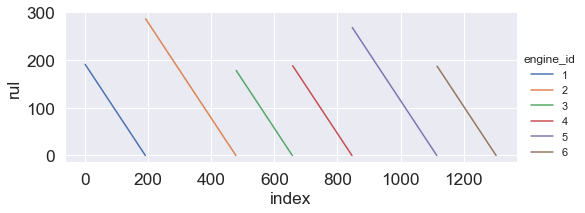

In [4]:
# Visualize the RUL curve of some engines (1,2,3,4,5,6)
g = sns.PairGrid(data=train_FD001.reset_index().query('engine_id < 7') ,
                 x_vars=["index"],
                 y_vars=['rul'],
                 hue="engine_id", height=3, aspect=2.5)

g = g.map(plt.plot, alpha=1)
g = g.add_legend()

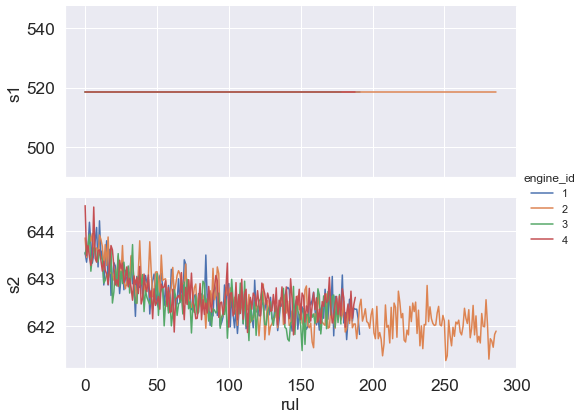

In [5]:
# Visualize some sensor curves of some engines 
g = sns.PairGrid(data=train_FD001.query('engine_id < 5') ,
                 x_vars=["rul"],
                 y_vars=['s1','s2'],
                 hue="engine_id", height=3, aspect=2.5)

g = g.map(plt.plot, alpha=1)
g = g.add_legend()

# As shown in the figure, some sensors are not related to RUL. 
# The values of some sensors change with the state of the machine. 
# Visualization can help filter features

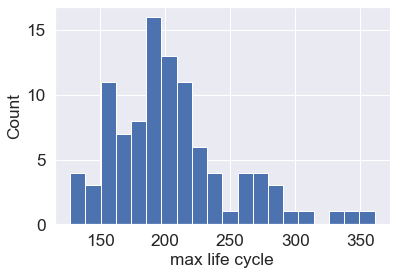

In [6]:
# Distribution of maximum life cycle
train_FD001[['engine_id', 'rul']].groupby('engine_id').apply(np.max)["rul"].hist(bins=20)
plt.xlabel("max life cycle")
plt.ylabel("Count")
plt.show()

**Can you do more visualization？ Please give a simple summary or explanation for each visualization**

<AxesSubplot:>

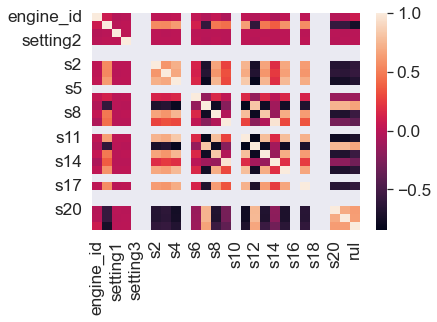

In [7]:
# Generate heatmap for parameter correlation
sns.heatmap(train_FD001.corr())

In [8]:
# prepare the data and normalization
train_y = train_FD001['rul']
features = train_FD001.columns.drop(['engine_id', 'cycle', 'rul'])
train_x = train_FD001[features]
test_x = test_FD001[features]

# z score normalization
mean = train_x.mean()
std = train_x.std()
std.replace(0, 1, inplace=True)

train_x = (train_x - mean) / std
test_x = (test_x - mean) / std

from sklearn.utils import shuffle
x, y = shuffle(train_x, train_y)

**Here only the values at each time point (cycle) are used to predict the RUL. Temporal relationship is ignored. How to use Temporal relationship?**

tip : Sliding Window

**Response:**

Temporal relationship could be used through using more than one row of an engine id at a time. This can be achieved with a sliding window approach. A fixed number of rows could be input into a model and the RUL of the last row could be used as a target for this sliding window. The sliding window could then slide over all the data of a specific engine id to calculate the RUL of the last row in the input data.

# Modeling

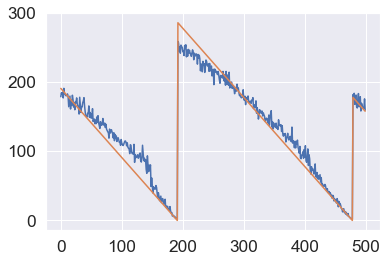

In [9]:
# Random Forest with default Hyper parameters
rf_model = RandomForestRegressor()
rf_model.fit(x,y)
rf_prediction = rf_model.predict(train_x)
plt.plot(rf_prediction[:500])
plt.plot(train_FD001["rul"][:500])
plt.show()

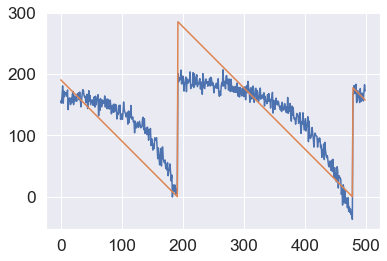

In [10]:
# Lasso model with default Hyper parameters
ls_model = LassoCV()
ls_model.fit(x,y)
ls_prediction = ls_model.predict(train_x)
plt.plot(ls_prediction[:500])
plt.plot(train_FD001["rul"][:500])
plt.show()

**How to tune hyperparameters and select models?** 

**Response:**

First we define the Hyperparameters for each model. Important is, that the set of hyperparameters differs between the models.  For example for the Random Forest: depth of trees or number of estimators. For the Lasso model suitable Hyperparameters are: alphas, normalize or max_iter. Then we tune every model for their set of Hyperparameters using GridSearchCV. Afterwards we select the model that performs best.

**Neural network model?**

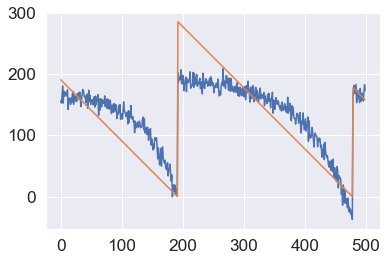

In [11]:
from sklearn.linear_model import LinearRegression

lr_model = LinearRegression()
lr_model = lr_model.fit(x,y)
lr_prediction = lr_model.predict(train_x)
plt.plot(lr_prediction[:500])
plt.plot(train_FD001["rul"][:500])
plt.show()

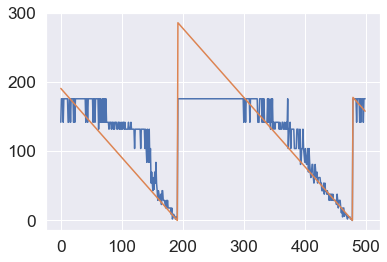

In [12]:
from sklearn.neural_network import MLPClassifier

mlp_model = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
mlp_model.fit(x, y)
mlp_prediction = mlp_model.predict(train_x)
plt.plot(mlp_prediction[:500])
plt.plot(train_FD001["rul"][:500])
plt.show()

# Evaluation

In [13]:
# Since only the value at one time point is used, it can be seen that a lot of data in the test set is not used

test_x['engine_id'] = test_FD001['engine_id']
test_input = []
for id in test_x['engine_id'].unique():
  test_input.append(test_x[test_x['engine_id']==id].iloc[-1,:-1].values)

test_input = np.array(test_input)

In [14]:
# Random forest

rf_test_prediction = rf_model.predict(test_input)

rf_rmse = np.sqrt(mean_squared_error(rf_test_prediction, RUL_FD001.values.reshape(-1)))

print("The RMSE of random forest on test dataset FD001 is ",rf_rmse)

The RMSE of random forest on test dataset FD001 is  33.01458239929744


In [15]:
# Lasso model

ls_test_prediction = ls_model.predict(test_input)

ls_rmse = np.sqrt(mean_squared_error(ls_test_prediction, RUL_FD001.values.reshape(-1)))

print("The RMSE of Lasso model on test dataset FD001 is ",ls_rmse)

The RMSE of Lasso model on test dataset FD001 is  32.01685917494252


In [16]:
lr_test_prediction = lr_model.predict(test_input)

lr_rmse = np.sqrt(mean_squared_error(lr_test_prediction, RUL_FD001.values.reshape(-1)))

print("The RMSE of Linear Regression model on test dataset FD001 is ",lr_rmse)

The RMSE of Linear Regression model on test dataset FD001 is  32.04109478174249


In [17]:
mlp_test_prediction = mlp_model.predict(test_input)

mlp_rmse = np.sqrt(mean_squared_error(mlp_test_prediction, RUL_FD001.values.reshape(-1)))

print("The RMSE of Linear Regression model on test dataset FD001 is ",mlp_rmse)

The RMSE of Linear Regression model on test dataset FD001 is  27.273980274246735


**What is your best result? If the used model is interpretable, what other conclusions can be summarized**

**Response:**

The best result is provided by the MLP Regression model. The RSME is lowest with 27.27 on the test data. Unfortunately the model is hard to interpret, because of the hidden layers and many parameters. The loss is decreasing over the iterations.

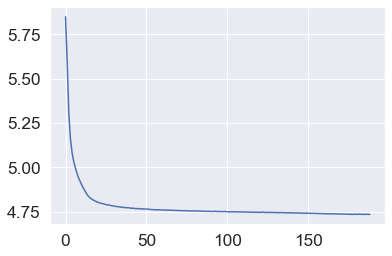

In [18]:
plt.plot(mlp_model.loss_curve_)
plt.show()